In [1]:
import yt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy import units as u, constants  as c
import os

pc = c.pc.cgs.value
kB  = c.k_B.cgs.value
Msun = c.M_sun.cgs.value
G = c.G.cgs.value
Myr = u.Myr.in_units("s")

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "text.latex.preamble" : r'\boldmath'
})

In [2]:
files = ["SILCC_hdf5_plt_cnt_0700", "SILCC_hdf5_plt_cnt_1080", "SILCC_hdf5_plt_cnt_1600", "SILCC_hdf5_plt_cnt_2100"]
#files = 4*["SILCC_hdf5_plt_cnt_1080"]
ctr = [-80*pc, -150*pc, 0*pc]
radius=120

In [15]:
## ONLY for the tests. For the actual plots, copy stuff from cluster

time = []
Tvw = []
nvw = []
vff = []

for f in files:
    ds = yt.load("/Users/girichidis/Physics/Data/SILCC-cubic/L7-CM6/"+f)

    time.append(ds.current_time.in_units("Myr"))
    # create sphere around ctr
    sp = ds.sphere(ctr, (radius, "pc"))
    
    vol = sp[("gas", "cell_volume")]
    Vtot = np.sum(vol)
    
    # get temperature and density data
    for field in [("gas", "number_density"), ("gas", "temperature")]:
        dat = sp[field]
        vw  = np.sum(dat*vol)/Vtot
        if field == ("gas", "number_density"):
            nvw.append(vw)
        if field == ("gas", "temperature"):
            Tvw.append(vw)
            idx = np.where(dat > 8e5)
            vff.append(np.sum(vol[idx])/Vtot)
            
data = np.vstack((time,Tvw,nvw,vff)).T
np.savetxt("datafiles/time-evol-temp-dens.txt", data, header="time   temp(vw)   n(vw)   vff(T>8e5K)")

yt : [INFO     ] 2025-02-20 11:49:34,410 Parameters: current_time              = 220784161681940.56
yt : [INFO     ] 2025-02-20 11:49:34,411 Parameters: domain_dimensions         = [8 8 8]
yt : [INFO     ] 2025-02-20 11:49:34,412 Parameters: domain_left_edge          = [-7.715e+20 -7.715e+20 -7.715e+20]
yt : [INFO     ] 2025-02-20 11:49:34,413 Parameters: domain_right_edge         = [7.715e+20 7.715e+20 7.715e+20]
yt : [INFO     ] 2025-02-20 11:49:34,413 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2025-02-20 11:49:40,928 Parameters: current_time              = 340597785179995.1
yt : [INFO     ] 2025-02-20 11:49:40,929 Parameters: domain_dimensions         = [8 8 8]
yt : [INFO     ] 2025-02-20 11:49:40,930 Parameters: domain_left_edge          = [-7.715e+20 -7.715e+20 -7.715e+20]
yt : [INFO     ] 2025-02-20 11:49:40,931 Parameters: domain_right_edge         = [7.715e+20 7.715e+20 7.715e+20]
yt : [INFO     ] 2025-02-20 11:49:40,931 Parameters: cosmological_simulation   = 0

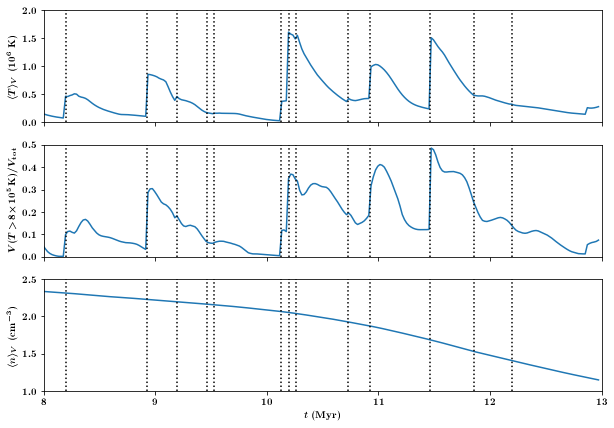

In [4]:
# plot computed data from helix
dat = np.loadtxt("datafiles/time-evol-temp-dens-nelec-R100.txt")

# also load SN data file
SNe = np.loadtxt("datafiles/SNoutput.dat")

# select all SNe that occur within a radius of 100 pc around ctr
SN_rad = np.sqrt((SNe[:,1]-ctr[0])**2 + (SNe[:,2]-ctr[1])**2 + (SNe[:,3]-ctr[2])**2)/pc
idx = np.where(SN_rad < 100)
idx2 = np.where(SN_rad < 120)

fig, ax = plt.subplots(figsize=(10,7), nrows=3, sharex=True)
ax[0].plot(dat[:,0], dat[:,1]/1e6)
ax[2].plot(dat[:,0], dat[:,2])
ax[1].plot(dat[:,0], dat[:,3])
ax[2].set_xlim(8,13)
ax[0].set_ylim(0,2)
ax[2].set_ylim(1,2.5)
ax[1].set_ylim(0,0.5)
ax[0].set_ylabel("$\\langle T\\rangle_V~\\mathrm{(10^6~K)}$")
ax[2].set_ylabel("$\\langle n\\rangle_V~\\mathrm{(cm^{-3})}$")
ax[1].set_ylabel("$V(T\\!>\\!8\\!\\times\\!10^5\\,\\mathrm{K}) / V_\\mathrm{tot}$")
ax[2].set_xlabel("$t~\\mathrm{(Myr)}$")
ax[0].vlines(SNe[idx,0]/Myr, 0,2,   color="k", ls=":")
ax[2].vlines(SNe[idx,0]/Myr, 1,2.5, color="k", ls=":")
ax[1].vlines(SNe[idx,0]/Myr, 0,0.5, color="k", ls=":")
#ax[2].vlines(SNe[idx2]/Myr, 0,0.5, color="grey", ls=":")
fig.savefig("plots/time-evol-average-T-n-hot-vff.pdf", bbox_inches="tight")

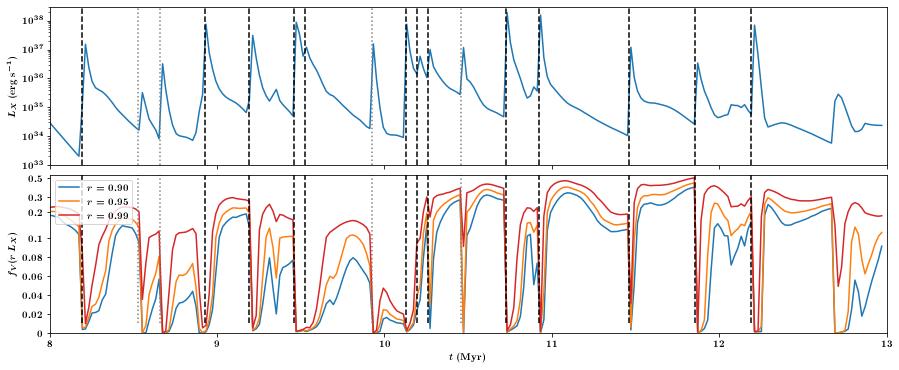

In [5]:
# plot fraction of volume from which X of emission originates from
# fixed radius approach

dat = np.loadtxt("datafiles/time-evol-emission-volume-R100.txt")

# also load SN data file
SNe = np.loadtxt("datafiles/SNoutput.dat")

# select all SNe that occur within a radius of 100 pc around ctr
SN_rad = np.sqrt((SNe[:,1]-ctr[0])**2 + (SNe[:,2]-ctr[1])**2 + (SNe[:,3]-ctr[2])**2)/pc
idx = np.where(SN_rad < 100)
idx2 = np.where((SN_rad >=100) & (SN_rad < 120))

fig, ax = plt.subplots(figsize=(15,6), nrows=2, sharex=True)
ax[0].plot(dat[:,0], dat[:,1])
ax[1].plot(dat[:,0], dat[:,5], label="$r=0.90$", color="C0")
ax[1].plot(dat[:,0], dat[:,6], label="$r=0.95$", color="C1")
ax[1].plot(dat[:,0], dat[:,7], label="$r=0.99$", color="C3")
ax[1].vlines(SNe[idx,0]/Myr, 0.01,0.55, color="k", ls="--")
ax[0].vlines(SNe[idx,0]/Myr, 1e33,3e38, color="k", ls="--")
ax[1].vlines(SNe[idx2,0]/Myr, 0.01,0.55, color="grey", ls=":")
ax[0].vlines(SNe[idx2,0]/Myr, 1e33,3e38, color="grey", ls=":")
ax[0].set_yscale("log")
ax[1].set_yscale("symlog", linthresh=0.1)
ax[1].set_yticks([0,0.02,0.04,0.06,0.08,0.1,0.2,0.3,0.5])
ax[1].set_yticklabels(["$0$","$0.02$","$0.04$","$0.06$","$0.08$","$0.1$","$0.2$","$0.3$","$0.5$"])
ax[0].set_ylim(1e33,3e38)
ax[1].set_xlim(8,13)
ax[1].set_ylim(0.0,0.55)
ax[1].legend(loc="upper left")
ax[1].set_xlabel("$t~\\mathrm{(Myr)}$")
ax[1].set_ylabel("$f_V(r\\,L_X)$")
ax[0].set_ylabel("$L_X~\\mathrm{(erg\\,s^{-1})}$")
fig.subplots_adjust(hspace=0.06)
fig.savefig("plots/time-evol-LXtot-emission-volume.pdf", bbox_inches="tight")

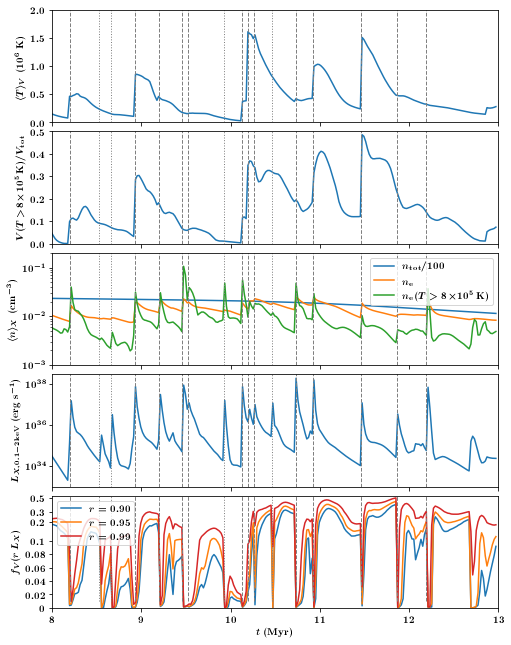

In [14]:
# time evol all in one
# plot computed data from helix
datTn = np.loadtxt("datafiles/time-evol-temp-dens-nelec-R100.txt")

datLf = np.loadtxt("datafiles/time-evol-emission-volume-R100.txt")

# also load SN data file
SNe = np.loadtxt("datafiles/SNoutput.dat")

# select all SNe that occur within a radius of 100 pc around ctr
SN_rad = np.sqrt((SNe[:,1]-ctr[0])**2 + (SNe[:,2]-ctr[1])**2 + (SNe[:,3]-ctr[2])**2)/pc
idx = np.where(SN_rad < 100)
idx2 = np.where((SN_rad >= 100) & (SN_rad < 120))

fig, ax = plt.subplots(figsize=(8,11), nrows=5, sharex=True)
ax[0].plot(datTn[:,0], datTn[:,1]/1e6)
ax[0].set_ylabel("$\\langle T\\rangle_V~\\mathrm{(10^6~K)}$")
ax[0].set_ylim(0,2)

ax[1].plot(datTn[:,0], datTn[:,3])
ax[1].set_ylabel("$V(T\\!>\\!8\\!\\times\\!10^5\\,\\mathrm{K}) / V_\\mathrm{tot}$")
ax[1].set_ylim(0,0.5)

# density
ax[2].plot(datTn[:,0], datTn[:,2]/100., label="$n_\\mathrm{tot}/100$")
ax[2].set_ylabel("$\\langle n\\rangle_X~\\mathrm{(cm^{-3})}$")
ax[2].plot(datTn[:,0], datTn[:,4], label="$n_\\mathrm{e}$")
ax[2].plot(datTn[:,0], datTn[:,5], label="$n_\\mathrm{e}(T>8\\!\\times\\!10^5\\,\\mathrm{K})$")
ax[2].set_yscale("log")
ax[2].set_ylim(1e-3,2e-1)
ax[2].legend(loc="upper right")

ax[3].plot(datLf[:,0], datLf[:,1])
ax[3].set_ylabel("$L_{X,0.1-2\\,\\mathrm{keV}}~\\mathrm{(erg\\,s^{-1})}$")
ax[3].set_ylim(1e33,3e38)
ax[3].set_yscale("log")

ax[4].plot(datLf[:,0], datLf[:,5], label="$r=0.90$", color="C0")
ax[4].plot(datLf[:,0], datLf[:,6], label="$r=0.95$", color="C1")
ax[4].plot(datLf[:,0], datLf[:,7], label="$r=0.99$", color="C3")

ax[4].set_yscale("symlog", linthresh=0.1)
ax[4].set_yticks([0,0.02,0.04,0.06,0.08,0.1,0.2,0.3,0.5])
ax[4].set_yticklabels(["$0$","$0.02$","$0.04$","$0.06$","$0.08$","$0.1$","$0.2$","$0.3$","$0.5$"])
ax[4].set_xlim(8,13)
ax[4].set_ylim(0.0,0.55)
ax[4].legend(loc="upper left")
ax[4].set_ylabel("$f_V(r\\,L_X)$")

ax[0].vlines(SNe[idx,0]/Myr, 0,2,       color="grey", ls="--", lw=1)
ax[1].vlines(SNe[idx,0]/Myr, 0,0.5,     color="grey", ls="--", lw=1)
ax[2].vlines(SNe[idx,0]/Myr, 1e-3,2e-1, color="grey", ls="--", lw=1)
ax[3].vlines(SNe[idx,0]/Myr, 1e33,3e38, color="grey", ls="--", lw=1)
ax[4].vlines(SNe[idx,0]/Myr, 0.01,0.55, color="grey", ls="--", lw=1)

ax[0].vlines(SNe[idx2,0]/Myr, 0,2,       color="grey", ls=":", lw=1)
ax[1].vlines(SNe[idx2,0]/Myr, 0,0.5,     color="grey", ls=":", lw=1)
ax[2].vlines(SNe[idx2,0]/Myr, 1e-3,2e-1, color="grey", ls=":", lw=1)
ax[3].vlines(SNe[idx2,0]/Myr, 1e33,3e38, color="grey", ls=":", lw=1)
ax[4].vlines(SNe[idx2,0]/Myr, 0.01,0.55, color="grey", ls=":", lw=1)

ax[4].set_xlabel("$t~\\mathrm{(Myr)}$")

fig.subplots_adjust(hspace=0.08)

fig.savefig("plots/time-evol-all-sphere-R100pc.pdf", bbox_inches="tight")

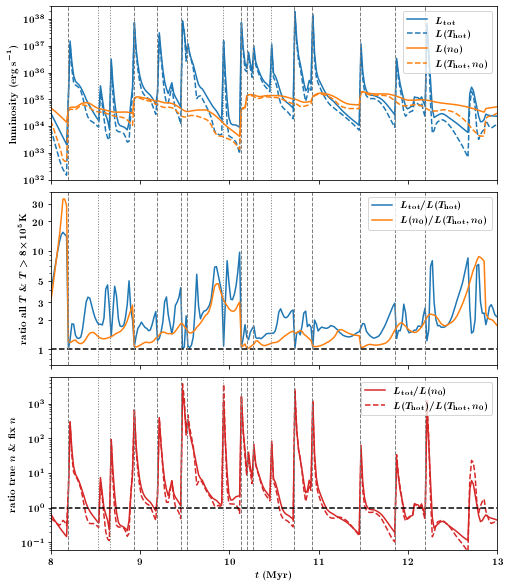

In [189]:
# plot different recipes for number density
dat = np.loadtxt("datafiles/time-evol-emission-test-fixed-n-R100.txt.1")
fig, ax = plt.subplots(figsize=(8,10), nrows=3, sharex=True)
label1 = "$L_\\mathrm{tot}$"
label2 = "$L(T>8\\!\\times\\!10^5\\mathrm{K})$"
label3 = "$L(n=n_0)$"
label4 = "$L(T>8\\!\\times\\!10^5\\mathrm{K},n=n_0)$"
label1 = "$L_\\mathrm{tot}$"
label2 = "$L(T_\\mathrm{hot})$"
label3 = "$L(n_0)$"
label4 = "$L(T_\\mathrm{hot},n_0)$"
ax[0].semilogy(dat[:,0], dat[:,1], label=label1, color="C0")
ax[0].semilogy(dat[:,0], dat[:,5], label=label2, color="C0", ls="--")
ax[0].semilogy(dat[:,0], dat[:,2], label=label3, color="C1")
ax[0].semilogy(dat[:,0], dat[:,6], label=label4, color="C1", ls="--")
ax[0].legend()
ax[0].set_ylabel("\\textbf{luminosity }$\\mathrm{(erg\,s}^{-1})$")

# rel. difference Ltot and Ltot(hot)
#label1 = "$|L_\\mathrm{tot}-L(T>8\\!\\times\\!10^5\\mathrm{K})|/L(T>8\\!\\times\\!10^5\\mathrm{K})$"
#label2 = "$|L(n=n_0)-L_\\mathrm{hot}(n=n_0)|/L_\\mathrm{hot}(n=n_0)$"
label1 = "$L_\\mathrm{tot}/L(T>8\\!\\times\\!10^5\\mathrm{K})$"
label2 = "$L(n=n_0)/L(T>8\\!\\times\\!10^5\\mathrm{K},n=n_0)$"
label1 = "$L_\\mathrm{tot}/L(T_\\mathrm{hot})$"
label2 = "$L(n_0)/L(T_\\mathrm{hot},n_0)$"
#label1 = "\\textbf{re. difference }$L_\\mathrm{tot}-L_\\mathrm{tot,hot})$"
#ax[1].semilogy(dat[:,0], np.abs(dat[:,1]-dat[:,5])/dat[:,5], label=label1)
#ax[1].semilogy(dat[:,0], np.abs(dat[:,2]-dat[:,6])/dat[:,6], label=label2)
ax[1].semilogy(dat[:,0], np.abs(dat[:,1]/dat[:,5]), label=label1)
ax[1].semilogy(dat[:,0], np.abs(dat[:,2]/dat[:,6]), label=label2)
ax[1].semilogy([8,13], [1,1], ls="--", color="k")
ax[1].legend()
ax[1].set_yticks([1,2,3,5,10,20,30])
ax[1].set_yticklabels(["$1$","$2$","$3$","$5$","$10$","$20$","$30$"])
ax[1].set_ylabel("$\\mathrm{ratio~all~}T~\\&~T>8\\!\\times\\!10^5\\,\\mathrm{K}$")

# rel. difference Ltot and Ltot_fixedn and Ltot(hot) and Ltot_fixedn(hot)
#label1 = "$|L_\\mathrm{tot}-L(n=n_0)|/L_\\mathrm{tot}$"
#label2 = "$|L_\\mathrm{tot,hot}-L_\\mathrm{hot}(n=n_0)|/L_\\mathrm{tot,hot}$"
label1 = "$L_\\mathrm{tot}/L(n=n_0)$"
label2 = "$L(T>8\\!\\times\\!10^5\\mathrm{K})/L(T>8\\!\\times\\!10^5\\mathrm{K},n=n_0)$"
label1 = "$L_\\mathrm{tot}/L(n_0)$"
label2 = "$L(T_\\mathrm{hot})/L(T_\\mathrm{hot},n_0)$"
#ax[2].semilogy(dat[:,0], np.abs(dat[:,1]-dat[:,2])/dat[:,1], label=label1, ls="-", color="C3")
#ax[2].semilogy(dat[:,0], np.abs(dat[:,5]-dat[:,6])/dat[:,5], label=label2, ls="--", color="C3")
ax[2].semilogy(dat[:,0], np.abs(dat[:,1]/dat[:,2]), label=label1, ls="-", color="C3")
ax[2].semilogy(dat[:,0], np.abs(dat[:,5]/dat[:,6]), label=label2, ls="--", color="C3")
ax[2].semilogy([8,13], [1,1], ls="--", color="k")
ax[2].legend()
ax[2].set_xlim(8,13)
ax[2].set_xlabel("$t~\\mathrm{(Myr)}$")
ax[2].set_ylabel("$\\mathrm{ratio~true~}n~\\&~\\mathrm{fix}~n$")

# select all SNe that occur within a radius of 100 pc around ctr
SN_rad = np.sqrt((SNe[:,1]-ctr[0])**2 + (SNe[:,2]-ctr[1])**2 + (SNe[:,3]-ctr[2])**2)/pc
idx = np.where(SN_rad < 100)
idx2 = np.where((SN_rad >= 100) & (SN_rad < 120))

ax[0].set_ylim(1e32,3e38)
ax[1].set_ylim(0.7,40)
ax[2].set_ylim(0.06,6e3)

# add SNe
ax[0].vlines(SNe[idx,0]/Myr, 1e32,3e38,   color="grey", ls="--", lw=1)
ax[1].vlines(SNe[idx,0]/Myr, 0.7,40,      color="grey", ls="--", lw=1)
ax[2].vlines(SNe[idx,0]/Myr, 0.06,6e3,    color="grey", ls="--", lw=1)

ax[0].vlines(SNe[idx2,0]/Myr, 1e32,3e38,  color="grey", ls=":", lw=1)
ax[1].vlines(SNe[idx2,0]/Myr, 0.7,40,     color="grey", ls=":", lw=1)
ax[2].vlines(SNe[idx2,0]/Myr, 0.06,6e3,   color="grey", ls=":", lw=1)

fig.subplots_adjust(hspace=0.07)
fig.savefig("plots/time-evol-luminosity-different-models-plus-ratios.pdf", bbox_inches="tight")

12.831954518408624